<a href="https://colab.research.google.com/github/CarysDT/Colab-Notebook/blob/main/Copy_of_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

You need to submit a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U3proj.

Ex.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU3proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU2proj.ipynb"

# Unit 4 Project: Using Hierarchies to Account for Dependence Between Groups

**Task**:

Two parts:

1. Propose a data set that's compatible with a hierarchical model structure built with pymc, and that potentially has some dependence between subgroups within the data set. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a model using pymc within the colab environment, on a data set of your choice, with the following restrictions
- You must have at least one piror and at least one hyperprior.
- Your model must have at least one seperate prior for each subgroup of the data set, and a at least one shared hyperior for all the groups.
- Any student may use the following data set: [basketball2324](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). I recommend trying to model TRB (total rebounds) by player position (pos). Also, I recommend pandas query function to splice and clean the data.



# George Kittle Heirarchical Model
George Kittle is a Tight End for the NFL team the 49ers which is a position similar to a Wide Reciever except that Tight Ends are also often used as a tackle. Because of their additional role of blocking their statistics for recieving yards are different than other positions such as Wide Receivers, which we will be comparing them to.

In [2]:
#load the data from my github page.
#sccr stands for soccer
url_ry = 'https://raw.githubusercontent.com/CarysDT/Data-Sci/refs/heads/main/Recieving%20Yards%20-%20Sheet1.csv'

#Turns the position column into a categorical variable
ry_data = pd.read_csv(url_ry,dtype={'position':'category'})
ry_data = ry_data.dropna()

In [3]:
ry_data

,name,position,yds
1,CeeDee Lamb,WR,1749.0
2,Tyreek Hill,WR,1799.0
3,Amon-Ra St. Brown,WR,1515.0
4,Evan Engram,TE,963.0
5,Michael Pittman,WR,1152.0
6,Keenan Allen,WR,1243.0
7,Stefon Diggs,WR,1183.0
8,A.J. Brown,WR,1456.0
9,Puka Nacua,WR,1486.0
10,Davante Adams,WR,1144.0


<Axes: ylabel='yds'>

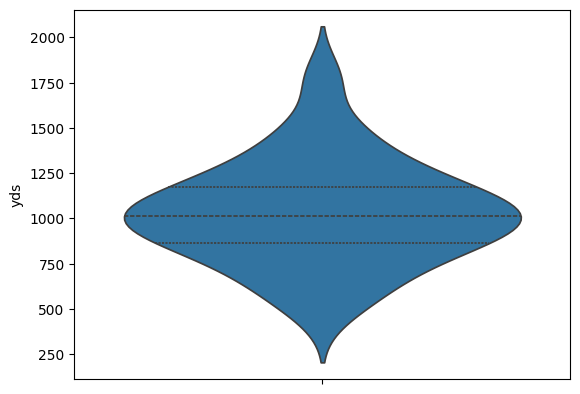

In [4]:
sns.violinplot(ry_data.yds,inner='quart')

(array([ 4.,  3.,  6.,  9., 12.,  8.,  3.,  3.,  0.,  2.]),
 array([ 466. ,  599.3,  732.6,  865.9,  999.2, 1132.5, 1265.8, 1399.1,
        1532.4, 1665.7, 1799. ]),
 <BarContainer object of 10 artists>)

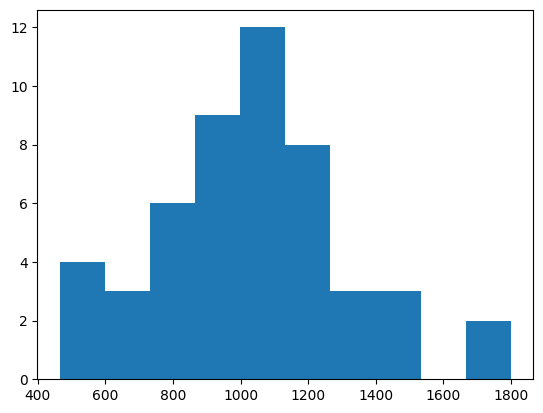

In [5]:
plt.hist(ry_data['yds'])

In [6]:
pos_idx = ry_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = ry_data.position.cat.categories

#puts coords in a dict, so pymc can read them
ry_coords = {"position": pos_codes}
ry_encode = pd.Categorical(ry_data['position'])
ry_encode
ry_idx = ry_encode.codes
ry_idx
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
ry_coords_coords = {"position": ry_encode.categories}
ry_coords

{'position': Index(['RB', 'TE', 'WR'], dtype='object')}

In [7]:
with pm.Model(coords=ry_coords) as ry_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 1000, sigma = 70, nu = 10)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 1000, nu =10)
    μ_nu = pm.Exponential('μ_nu', lam=1/30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "position", nu=μ_nu)

    σ = pm.Exponential('σ', lam=1/30,
                      dims = "position")
    ν = pm.HalfStudentT('ν', lam=1/30,
                      dims = "position", nu=10)

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[ry_idx],
                  sigma = σ[ry_idx],
                    nu = ν[ry_idx],
                  observed = ry_data.yds)

    #cs for chemshift, h for heirarchical
    idata_ry = pm.sample()

Output()

Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_nu'}>,
        <Axes: title={'center': 'μ_nu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

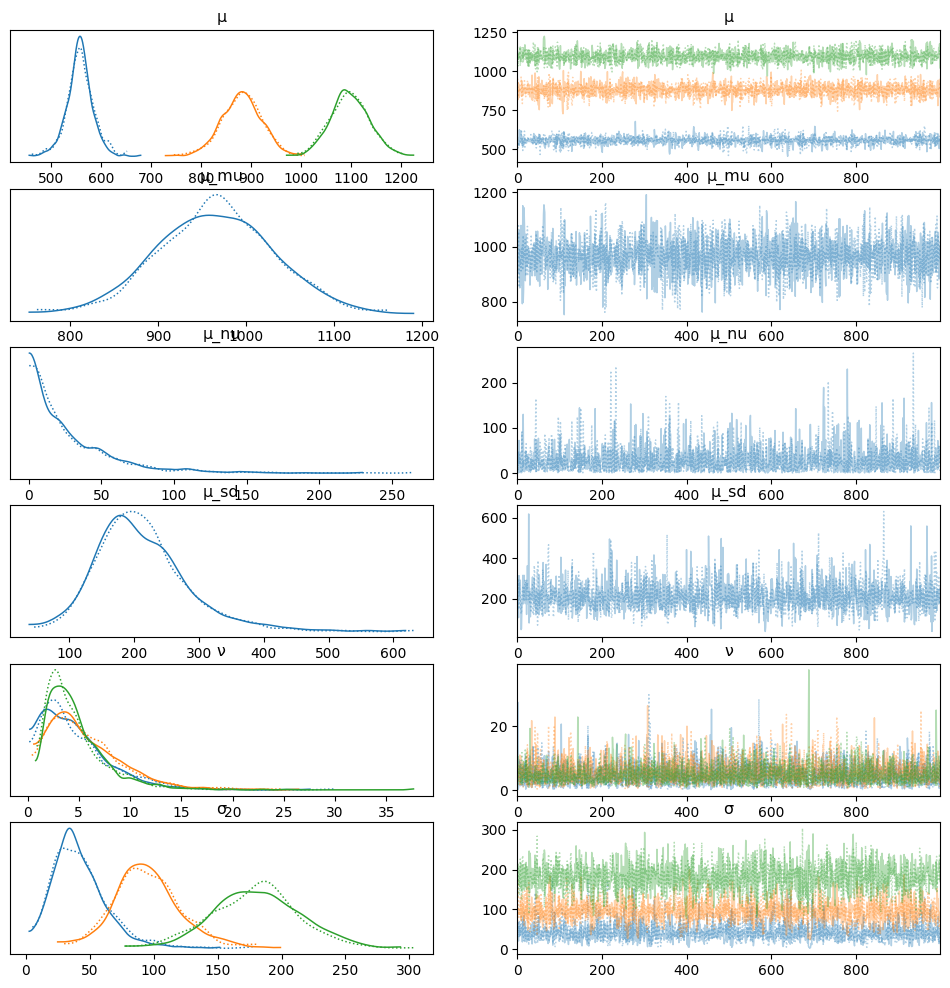

In [8]:
az.plot_trace(idata_ry)

In [9]:
idata_ry

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [10]:
az.rhat(idata_ry)

<xarray.Dataset> Size: 120B
Dimensions:   (position: 3)
Coordinates:
  * position  (position) <U2 24B 'RB' 'TE' 'WR'
Data variables:
    μ         (position) float64 24B 1.001 1.004 0.9998
    μ_mu      float64 8B 1.0
    μ_nu      float64 8B 1.002
    μ_sd      float64 8B 1.002
    ν         (position) float64 24B 1.001 0.9997 1.003
    σ         (position) float64 24B 1.002 1.002 1.001

array([<Axes: >], dtype=object)

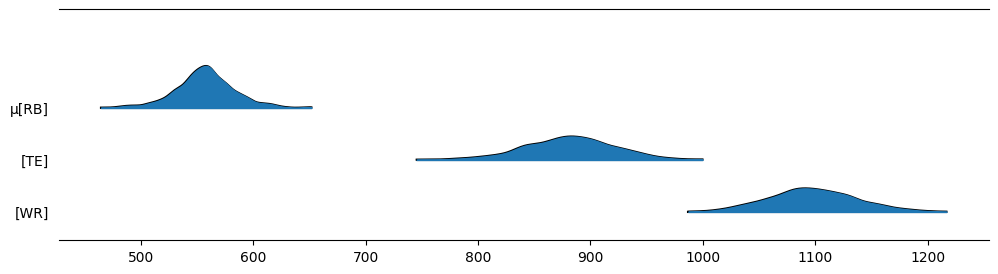

In [11]:
az.plot_forest(idata_ry, var_names=['μ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

Text(0.5, 1.0, 'Running Back')

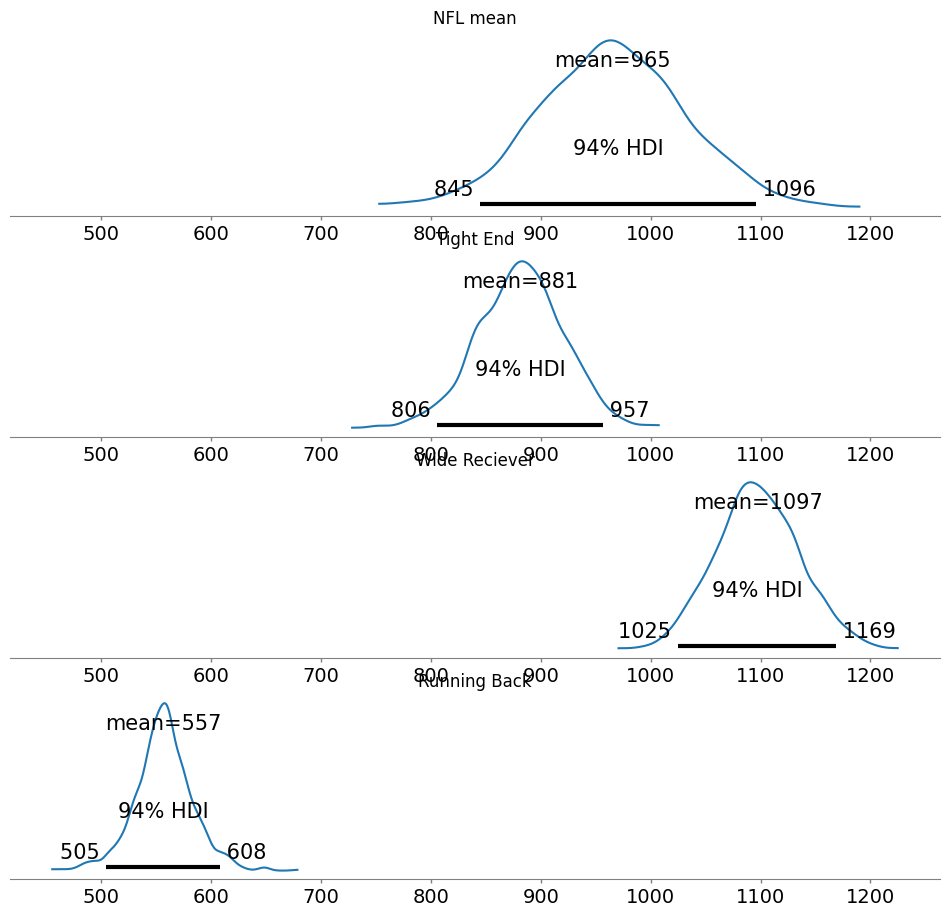

In [26]:
_, ax = plt.subplots(4, 1, figsize=(12, 11), sharex=True)

#plot the overall mean shooting percentage
az.plot_posterior(idata_ry, var_names='μ_mu', ax=ax[0])
ax[0].set_title(r"NFL mean")

#plot the fowrads shooting percentage
az.plot_posterior(idata_ry.posterior.sel(position="TE"), var_names='μ', ax=ax[1])
ax[1].set_title(r"Tight End")
az.plot_posterior(idata_ry.posterior.sel(position="WR"), var_names='μ', ax=ax[2])
ax[2].set_title(r"Wide Reciever")
az.plot_posterior(idata_ry.posterior.sel(position="RB"), var_names='μ', ax=ax[3])
ax[3].set_title(r"Running Back")

# Analysis

Tight Ends on average were lower than Wide Recievers, which were much higher. This makes sense because Tight Ends do not get the ball as often because recieving is only half of their job, due to the fact that they also have to block. There are also less Tight Ends than Wide Recievers so it is also expected that there is a higher probability for a Wide Reciever to be open than a Tight End. However I was not expecting the average Wide Recievers yard mean to be so much higher than the NFL mean, but maybe this is due to more higher up recievers being present in the data, as well as Running Backs, who have a very low recieving yards to lower the NFL mean. Running Backs are often given the ball through hand-offs from the Quarterback, and are rarely given the ball through recieving, such as a slant play.

Now I will try to analyze a specific player who is a Tight End, George Kittle, I could not get this code to work but I left it here because I worked a long time on trying to get it to work

In [14]:
with pm.Model(coords=ry_coords) as ry_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 1000, sigma = 70, nu = 10)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 1000, nu =10)
    μ_nu = pm.Exponential('μ_nu', lam=1/30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "position", nu=μ_nu)

    σ = pm.Exponential('σ', lam=1/30,
                      dims = "position")
    ν = pm.HalfStudentT('ν', lam=1/30,
                      dims = "position", nu=10)
    σ_2 = pm.Exponential('σ_2', lam=1/30)
    ν_2 = pm.HalfStudentT('ν_2', lam=1/30, nu=10)
    #likelihood; same as before
    μ_0 = pm.StudentT('μ_0', mu = μ, sigma = σ[ry_idx],
                    nu = ν[ry_idx])
    y = pm.StudentT('y',
                  mu = μ_0,
                  sigma = σ_2,
                    nu = ν_2,
                  observed = ry_data.yds)

    #cs for chemshift, h for heirarchical
    idata_ry = pm.sample()

AssertionError: Could not broadcast dimensions. Broadcasting is only allowed along axes that have a statically known length 1. Use `specify_broadcastable` to inform PyTensor of a known shape.
Apply node that caused the error: Assert{msg='Could not broadcast dimensi...'}(50, Eq.0)
Toposort index: 24
Inputs types: [ScalarType(int8), TensorType(bool, shape=())]
Inputs shapes: [(), ()]
Inputs strides: [(), ()]
Inputs values: [50, array(False)]
Outputs clients: [[TensorFromScalar(Assert{msg='Could not broadcast dimensi...'}.0)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.